In [1]:
import praw
import pandas as pd
from datetime import datetime
import time
import logging
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import matplotlib.pyplot as plt
import spacy
from collections import Counter
from nltk.sentiment import SentimentIntensityAnalyzer
# from transformers import pipeline

In [2]:
logging.basicConfig(filename='data_extraction.log', level=logging.INFO)
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/kyle/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/kyle/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/kyle/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
reddit = praw.Reddit(
    client_id='l13EfEFWXIo8ZHx6kndK8A',
    client_secret='wnQ35vd_ggELT219tsG6AKe0dUSAdg',
    user_agent='MacOS:redditScraper:v1.0 (by /u/kyle_stein)'
)

In [4]:
subreddit_name = 'Etoro'

In [5]:
def preprocess_text(text):
    # Remove HTML tags and special characters
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Perform lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    # Join the tokens back into a string
    processed_text = ' '.join(tokens)
    
    return processed_text

In [10]:
subreddit = reddit.subreddit(subreddit_name)

posts = []
comments_data = []

try:
    # Retrieve posts with pagination
    last_post_id = None
    while True:
        # Adjust the limit as needed
        posts_batch = list(subreddit.new(limit=100, params={'after': last_post_id}))
        if not posts_batch:
            break

        for post in posts_batch:
            post_data = {
                'title': post.title,
                'score': post.score,
                'id': post.id,
                'url': post.url,
                'num_comments': post.num_comments,
                'created_utc': datetime.fromtimestamp(post.created_utc),
                'body': post.selftext,
                'username': post.author.name if post.author else '[deleted]',
                'upvote_ratio': post.upvote_ratio,
                'is_original_content': post.is_original_content,
                'flair': post.link_flair_text,
                'is_video': post.is_video,
                'domain': post.domain,
                'is_self': post.is_self,
                'is_stickied': post.stickied,
                'over_18': post.over_18,
                'total_awards_received': post.total_awards_received,
                'gilded': post.gilded,
                'edited': post.edited,
                'comment_sort': post.comment_sort,
                'permalink': f'https://www.reddit.com{post.permalink}',
                'is_media': bool(post.media),
                'media_url': post.url if post.media else None,
                'is_crosspost': post.num_crossposts > 0,
                # 'original_subreddit': post.crosspost_parent.subreddit.display_name if post.num_crossposts > 0 else None,
                'stickied': post.stickied
            }
            posts.append(post_data)

            post.comments.replace_more(limit=None)  # Retrieve all comments, including nested ones
            for comment in post.comments.list():
                comment_data = {
                    'comment_id': comment.id,
                    'post_id': post.id,
                    'parent_id': comment.parent_id,
                    'comment_body': comment.body,
                    'comment_author': comment.author.name if comment.author else '[deleted]',
                    'comment_score': comment.score,
                    'comment_created_utc': datetime.fromtimestamp(comment.created_utc),
                    'comment_gilded': comment.gilded,
                    'comment_edited': comment.edited,
                    'comment_is_submitter': comment.is_submitter,
                    'comment_stickied': comment.stickied
                }
                comments_data.append(comment_data)

        last_post_id = posts_batch[-1].fullname
        time.sleep(1)  # Add a delay to avoid hitting rate limits

    df_posts = pd.DataFrame(posts)
    df_comments = pd.DataFrame(comments_data)

    # Data validation and cleaning
    df_posts['created_utc'] = pd.to_datetime(df_posts['created_utc'])
    df_comments['comment_created_utc'] = pd.to_datetime(df_comments['comment_created_utc'])

    # Handle missing values
    df_posts.fillna('', inplace=True)
    df_comments.fillna('', inplace=True)

    # Perform text preprocessing and feature engineering
    df_posts['body'] = df_posts['body'].apply(preprocess_text)
    df_comments['comment_body'] = df_comments['comment_body'].apply(preprocess_text)

    # Save data to files
    # df_posts.to_csv('posts_data.csv', index=False)
    # df_comments.to_csv('comments_data.csv', index=False)

    logging.info("Data extraction completed successfully.")


except Exception as e:
    logging.error(f"An error occurred: {str(e)}")


In [11]:
df_posts

,title,score,id,url,num_comments,created_utc,body,username,upvote_ratio,is_original_content,...,over_18,total_awards_received,gilded,edited,comment_sort,permalink,is_media,media_url,is_crosspost,stickied
0,"Who wants a $24 bonus, current etoro users only",1,1c600hi,https://www.reddit.com/r/Etoro/comments/1c600h...,0,2024-04-16 22:40:40,24,bangersZONLY,1.00,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/1c600h...,False,,False,False
1,"Question about ETF's, CFD's and overnight fee's",2,1c5uri3,https://www.reddit.com/r/Etoro/comments/1c5uri...,0,2024-04-16 18:28:16,recently got etf buying noticed buttom said cf...,Lynardo12,1.00,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/1c5uri...,False,,False,False
2,Not allowing me to see the news,3,1c5b3uc,https://www.reddit.com/gallery/1c5b3uc,6,2024-04-16 03:36:41,say need funded acc yet u gold stock silver bi...,ChildhoodHumble7361,0.71,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/1c5b3u...,False,,False,False
3,Withdrawal Amount,4,1c4rykf,https://www.reddit.com/r/Etoro/comments/1c4ryk...,5,2024-04-15 12:26:05,hi guy planning buy house therefore need withd...,StinkFist207,0.84,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/1c4ryk...,False,,False,False
4,Let's find a winning copy trading strategy,3,1c3wqrz,https://www.reddit.com/r/Etoro/comments/1c3wqr...,8,2024-04-14 10:53:36,ive exploring copy trading platform like etoro...,copy-trader,0.67,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/1c3wqr...,False,,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,Am I able to trade the NASDAQ-100 on eToro?,2,12y7vzs,https://www.reddit.com/r/Etoro/comments/12y7vz...,4,2023-04-24 23:20:43,go say asset restricted viewonly mode,Specialist_Swimmer82,1.00,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/12y7vz...,False,,False,False
934,How to use eToro for Beginners? | N.02,0,12w5276,https://youtube.com/watch?v=NdLFkG3XRvk&featur...,0,2023-04-23 06:12:34,,CopyTradingForum,0.29,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/12w527...,True,https://youtube.com/watch?v=NdLFkG3XRvk&featur...,False,False
935,Silly question alert! I currently have $13 in ...,7,12w4wl8,https://www.reddit.com/r/Etoro/comments/12w4wl...,7,2023-04-23 06:04:50,,BLJKFPS,0.88,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/12w4wl...,False,,False,False
936,How to use eToro for Beginners?,0,12v1t52,https://youtube.com/watch?v=9T6pSXo3JvI&featur...,0,2023-04-22 05:26:02,,CopyTradingForum,0.50,False,...,False,0,0,False,confidence,https://www.reddit.com/r/Etoro/comments/12v1t5...,True,https://youtube.com/watch?v=9T6pSXo3JvI&featur...,False,False


In [12]:
# df_posts
df_comments

,comment_id,post_id,parent_id,comment_body,comment_author,comment_score,comment_created_utc,comment_gilded,comment_edited,comment_is_submitter,comment_stickied
0,kzt40w7,1c5b3uc,t3_1c5b3uc,new status system tragic designed make use eto...,ItsBrutalOutHere98,3,2024-04-16 05:06:15,0,False,False,False
1,kzu7cro,1c5b3uc,t3_1c5b3uc,etoro news shit anyway use breaking news apps ...,samuelsfx,1,2024-04-16 10:00:34,0,False,False,False
2,kzsxi9b,1c5b3uc,t3_1c5b3uc,refering much youve deposited silver tier stat...,Steyene,1,2024-04-16 03:45:54,0,False,False,False
3,kzswzfo,1c5b3uc,t3_1c5b3uc,lol good joke,freedomsearcher2611,0,2024-04-16 03:39:09,0,False,False,False
4,kzsxlab,1c5b3uc,t1_kzsxi9b,iv always news confusing bit,ChildhoodHumble7361,3,2024-04-16 03:46:59,0,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
5702,jh34nlh,12tjz7w,t3_12tjz7w,reach directly support thing,Mardanis,1,2023-04-20 19:48:12,0,False,False,False
5703,jh4h8ay,12tjz7w,t3_12tjz7w,open ticket customer service change fill form ...,vincenzost,1,2023-04-21 04:24:27,0,False,False,False
5704,jh3eyl6,12tjz7w,t1_jh34nlh,well ill try anything laptop reach support hop...,Jelly-beans-be-like,2,2023-04-20 21:08:38,0,False,True,False
5705,jh5vabh,12tjz7w,t1_jh4h8ay,theyre refusing change lack finnish passport f...,Jelly-beans-be-like,1,2023-04-21 11:34:39,0,False,True,False


In [13]:
# df_posts.to_csv('posts_data.csv', index=False)
# df_comments.to_csv('comments_data.csv', index=False)

## Categorize

In [14]:
# Comment count categorization
comment_count_thresholds = [0, 10, 50, 100, 500]

posts_comment_categories = {}
for i in range(len(comment_count_thresholds) - 1):
    lower = comment_count_thresholds[i]
    upper = comment_count_thresholds[i + 1]
    subset = df_posts[(df_posts['num_comments'] > lower) & (df_posts['num_comments'] <= upper)]
    posts_comment_categories[f'{lower+1} to {upper} comments'] = subset


# Upvote count categorization
score_thresholds = [0, 10, 50, 100, 500]

posts_score_categories = {}
for i in range(len(score_thresholds) - 1):
    lower = score_thresholds[i]
    upper = score_thresholds[i + 1]
    subset = df_posts[(df_posts['score'] > lower) & (df_posts['score'] <= upper)]
    posts_score_categories[f'{lower+1} to {upper} upvotes'] = subset

In [15]:
for category, subset in posts_comment_categories.items():
    print(f"{category}: {len(subset)} posts")

for category, subset in posts_score_categories.items():
    print(f"{category}: {len(subset)} posts")

1 to 10 comments: 654 posts
11 to 50 comments: 143 posts
51 to 100 comments: 3 posts
101 to 500 comments: 3 posts
1 to 10 upvotes: 773 posts
11 to 50 upvotes: 41 posts
51 to 100 upvotes: 2 posts
101 to 500 upvotes: 0 posts


### Sentiment Analysis

In [16]:
df_posts['sentiment'] = df_posts['body'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_comments['sentiment'] = df_comments['comment_body'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [17]:
average_post_sentiment = df_posts['sentiment'].mean()
print(f"Average sentiment of posts: {average_post_sentiment}")

average_comment_sentiment = df_comments['sentiment'].mean()
print(f"Average sentiment of comments: {average_comment_sentiment}")

Average sentiment of posts: 0.055572754823772115
Average sentiment of comments: 0.07374701158624075


In [18]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/kyle/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [19]:
sia = SentimentIntensityAnalyzer()

df_posts['sentiment'] = df_posts['body'].apply(lambda x: sia.polarity_scores(x)['compound'])
df_comments['sentiment'] = df_comments['comment_body'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [20]:
print(f"Average sentiment score for posts (VADER): {df_posts['sentiment'].mean()}")
print(f"Average sentiment score for comments (VADER): {df_comments['sentiment'].mean()}")

Average sentiment score for posts (VADER): 0.1994547974413646
Average sentiment score for comments (VADER): 0.15689304363062906


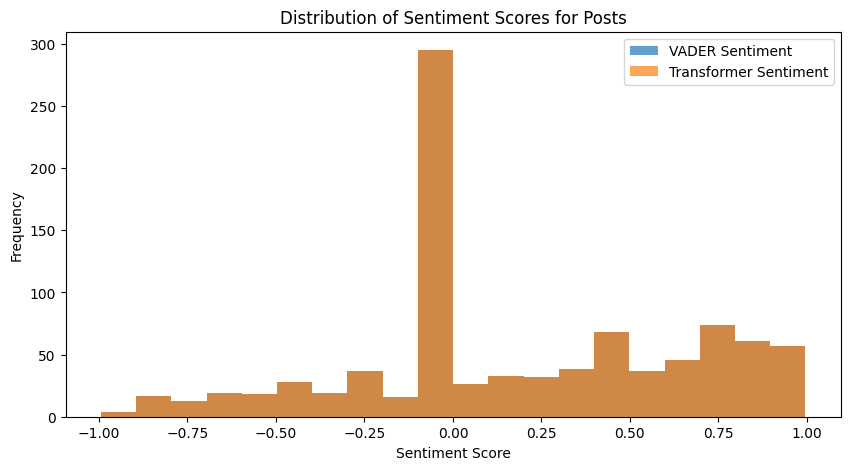

In [55]:
# Plot distribution of sentiment scores for posts
plt.figure(figsize=(10, 5))
plt.hist(df_posts['sentiment'], bins=20, alpha=0.7, label='VADER Sentiment')
# Assuming transformer sentiment scores are stored
plt.hist(df_posts['sentiment'], bins=20, alpha=0.7, label='Transformer Sentiment')
plt.title('Distribution of Sentiment Scores for Posts')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Repeat similar visualization for comments


In [24]:
print("Example posts with their sentiment scores:")
print(df_posts[['body', 'sentiment']].head())

Example posts with their sentiment scores:
                                                body  sentiment
0                                                 24     0.0000
1  recently got etf buying noticed buttom said cf...     0.3612
2  say need funded acc yet u gold stock silver bi...    -0.2263
3  hi guy planning buy house therefore need withd...    -0.5267
4  ive exploring copy trading platform like etoro...     0.9959


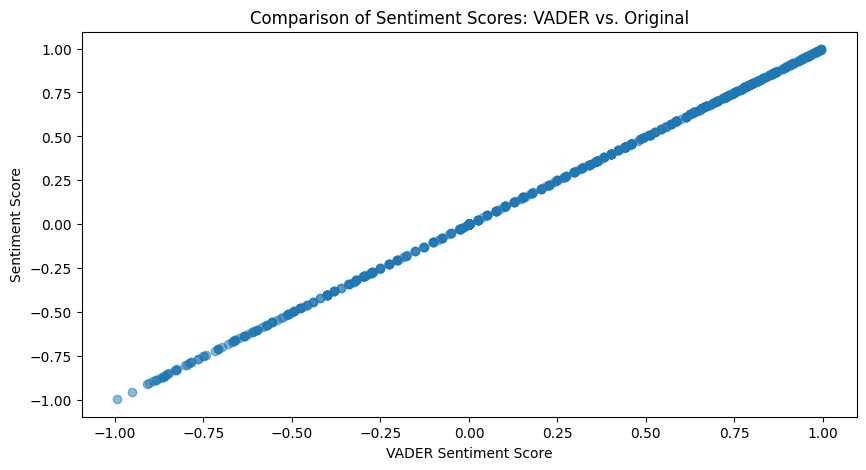

In [28]:
# Scatter plot to compare VADER and transformer sentiment scores
plt.figure(figsize=(10, 5))
plt.scatter(df_posts['sentiment'], df_posts['sentiment'], alpha=0.5)
plt.title('Comparison of Sentiment Scores: VADER vs. Original')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Sentiment Score')
plt.show()


In [29]:
# Compute correlation between VADER and transformer sentiment scores
correlation = df_posts['sentiment'].corr(df_posts['sentiment'])
print(f"Correlation between VADER and original sentiment scores for posts: {correlation}")

Correlation between VADER and original sentiment scores for posts: 1.0


In [30]:
min_post_sentiment = df_posts['sentiment'].min()
max_post_sentiment = df_posts['sentiment'].max()
min_comment_sentiment = df_comments['sentiment'].min()
max_comment_sentiment = df_comments['sentiment'].max()

print(f"Posts sentiment range: {min_post_sentiment} to {max_post_sentiment}")
print(f"Comments sentiment range: {min_comment_sentiment} to {max_comment_sentiment}")

Posts sentiment range: -0.9947 to 0.9959
Comments sentiment range: -0.9912 to 0.993


In [ ]:
min_post_sentiment = df_posts['sentiment'].min()
max_post_sentiment = df_posts['sentiment'].max()
min_comment_sentiment = df_comments['sentiment'].min()
max_comment_sentiment = df_comments['sentiment'].max()

print(f"Posts sentiment range: {min_post_sentiment} to {max_post_sentiment}")
print(f"Comments sentiment range: {min_comment_sentiment} to {max_comment_sentiment}")

Posts sentiment range: -0.9947 to 0.9959
Comments sentiment range: -0.9912 to 0.993


In [31]:
df_posts['num_comments'] = df_posts['num_comments'].astype(int)
df_posts['upvote_ratio'] = df_posts['upvote_ratio'].astype(float)

correlation_comments = df_posts['sentiment'].corr(df_posts['num_comments'])
correlation_upvotes = df_posts['sentiment'].corr(df_posts['upvote_ratio'])

print(f"Correlation of sentiment with number of comments: {correlation_comments}")
print(f"Correlation of sentiment with upvote ratio: {correlation_upvotes}")

Correlation of sentiment with number of comments: 0.008857001386569915
Correlation of sentiment with upvote ratio: 0.060274985150909816


### Time Series Analysis

In [56]:
df_posts['sentiment_category'] = pd.cut(df_posts['sentiment'], bins=[-1, -0.01, 0.01, 1], labels=['Negative', 'Neutral', 'Positive'])
positive_entities = [entity for sublist in df_posts[df_posts['sentiment_category'] == 'Positive']['named_entities'] for entity in sublist]
negative_entities = [entity for sublist in df_posts[df_posts['sentiment_category'] == 'Negative']['named_entities'] for entity in sublist]
positive_entity_counts = Counter(positive_entities)
negative_entity_counts = Counter(negative_entities)

print("Common entities in positive posts:")
for entity, count in positive_entity_counts.most_common(10):
    print(f"{entity[0]} ({entity[1]}): {count} occurrences")

print("\nCommon entities in negative posts:")
for entity, count in negative_entity_counts.most_common(10):
    print(f"{entity[0]} ({entity[1]}): {count} occurrences")

Common entities in positive posts:
one (CARDINAL): 46 occurrences
first (ORDINAL): 27 occurrences
2 (CARDINAL): 23 occurrences
today (DATE): 22 occurrences
1 (CARDINAL): 21 occurrences
500 (CARDINAL): 19 occurrences
two (CARDINAL): 14 occurrences
second (ORDINAL): 13 occurrences
200 (CARDINAL): 13 occurrences
1000 (CARDINAL): 13 occurrences

Common entities in negative posts:
one (CARDINAL): 25 occurrences
1 (CARDINAL): 14 occurrences
2 (CARDINAL): 12 occurrences
first (ORDINAL): 9 occurrences
3 (CARDINAL): 7 occurrences
today (DATE): 7 occurrences
1000 (CARDINAL): 6 occurrences
50 (CARDINAL): 6 occurrences
5 (CARDINAL): 6 occurrences
200 (CARDINAL): 5 occurrences


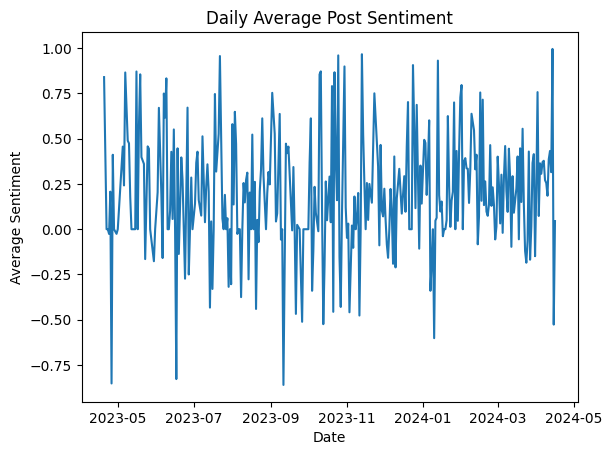

In [57]:
# Time series analysis of average post sentiment over time
df_posts['created_date'] = df_posts['created_utc'].dt.date
daily_sentiment = df_posts.groupby('created_date')['sentiment'].mean()

daily_sentiment.plot()
plt.title('Daily Average Post Sentiment')
plt.xlabel('Date')
plt.ylabel('Average Sentiment')
plt.show()

### User Analysis

In [58]:
user_post_counts = df_posts['username'].value_counts()
user_comment_counts = df_comments['comment_author'].value_counts()

In [59]:
print("Top users by post count:")
print(user_post_counts.head())

print("\nTop users by comment count:")
print(user_comment_counts.head())

Top users by post count:
username
CopyTradingForum    26
[deleted]           15
SandwichOk8222      11
chicanoharley        8
BetPaka              6
Name: count, dtype: int64

Top users by comment count:
comment_author
[deleted]            196
MrPopanz              86
Felsommer             81
Left_Actuary_7890     59
Unknown_Weirdo95      51
Name: count, dtype: int64


### Hyperlink Analysis

In [60]:
def extract_hyperlinks(text):
    return re.findall(r'(https?://[^\s]+)', text)

df_posts['hyperlinks'] = df_posts['body'].apply(extract_hyperlinks)

In [37]:
# total_hyperlinks = df_posts['hyperlinks'].explode().dropna().nunique()
# print(f"Total unique hyperlinks found in posts: {total_hyperlinks}")


# all_hyperlinks = df_posts['hyperlinks'].explode().dropna().tolist()
# hyperlink_counts = Counter(all_hyperlinks)

# print("Most common hyperlinks in posts:")
# for url, count in hyperlink_counts.most_common(10):
#     print(f"{url}: {count} occurrences")


# df_posts['hyperlink_count'] = df_posts['hyperlinks'].apply(lambda x: len(x) if isinstance(x, list) else 0)
# print(df_posts['hyperlink_count'].describe())



# plt.figure(figsize=(10, 6))
# df_posts['hyperlink_count'].hist(bins=range(1, df_posts['hyperlink_count'].max() + 1))
# plt.title('Distribution of Hyperlinks per Post')
# plt.xlabel('Number of Hyperlinks')
# plt.ylabel('Number of Posts')
# plt.grid(False)
# plt.show()


### NER

In [38]:
nlp = spacy.load("en_core_web_sm")

df_posts['named_entities'] = df_posts['body'].apply(lambda x: [(ent.text, ent.label_) for ent in nlp(x).ents])

In [39]:
# Flatten the list of entities from all posts and count occurrences
all_entities = [entity for sublist in df_posts['named_entities'] for entity in sublist]
entity_counts = Counter(all_entities)

print("Most common named entities in posts:")
for entity, count in entity_counts.most_common(10):
    print(f"{entity[0]} ({entity[1]}): {count} occurrences")

Most common named entities in posts:
one (CARDINAL): 76 occurrences
2 (CARDINAL): 37 occurrences
1 (CARDINAL): 37 occurrences
first (ORDINAL): 36 occurrences
today (DATE): 32 occurrences
500 (CARDINAL): 21 occurrences
1000 (CARDINAL): 19 occurrences
3 (CARDINAL): 18 occurrences
two (CARDINAL): 18 occurrences
200 (CARDINAL): 18 occurrences


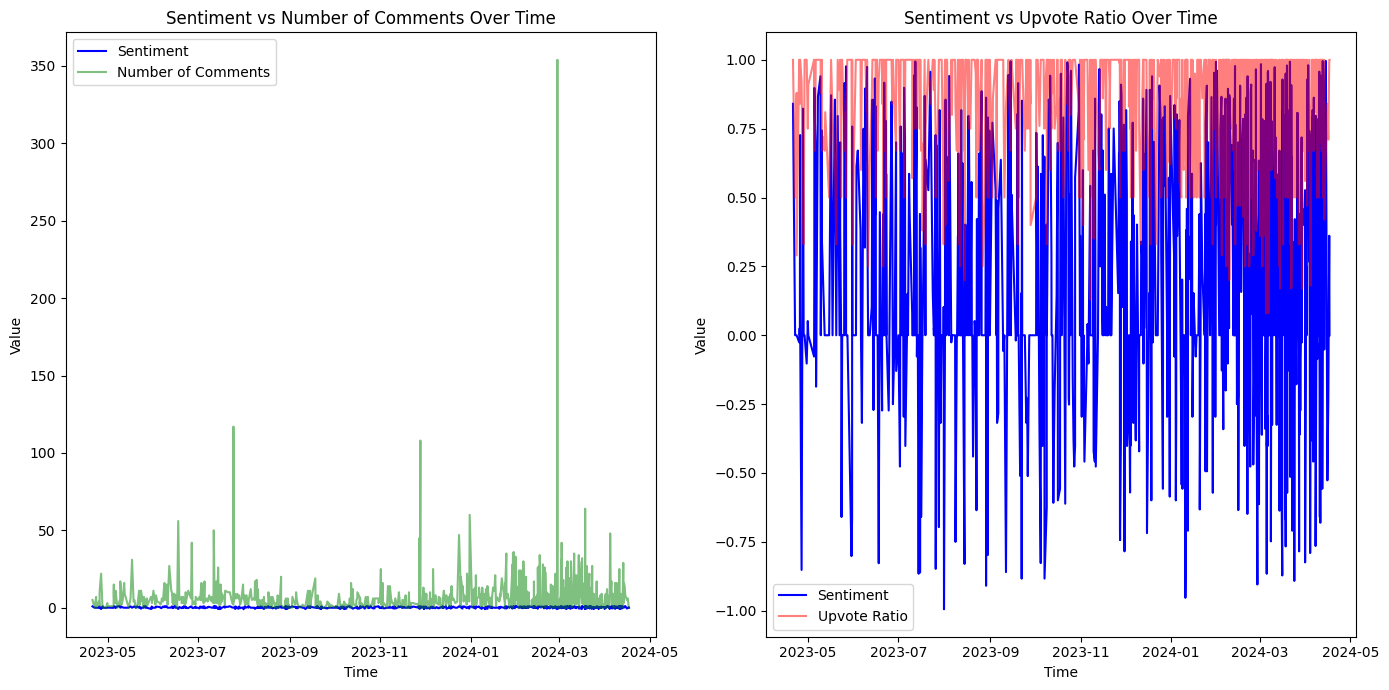

In [40]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(df_posts['created_utc'], df_posts['sentiment'], label='Sentiment', color='blue')
plt.plot(df_posts['created_utc'], df_posts['num_comments'], label='Number of Comments', color='green', alpha=0.5)
plt.title('Sentiment vs Number of Comments Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(df_posts['created_utc'], df_posts['sentiment'], label='Sentiment', color='blue')
plt.plot(df_posts['created_utc'], df_posts['upvote_ratio'], label='Upvote Ratio', color='red', alpha=0.5)
plt.title('Sentiment vs Upvote Ratio Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()

plt.tight_layout()
plt.show()

### Sentiment Trends Over Time with Rolling Averages

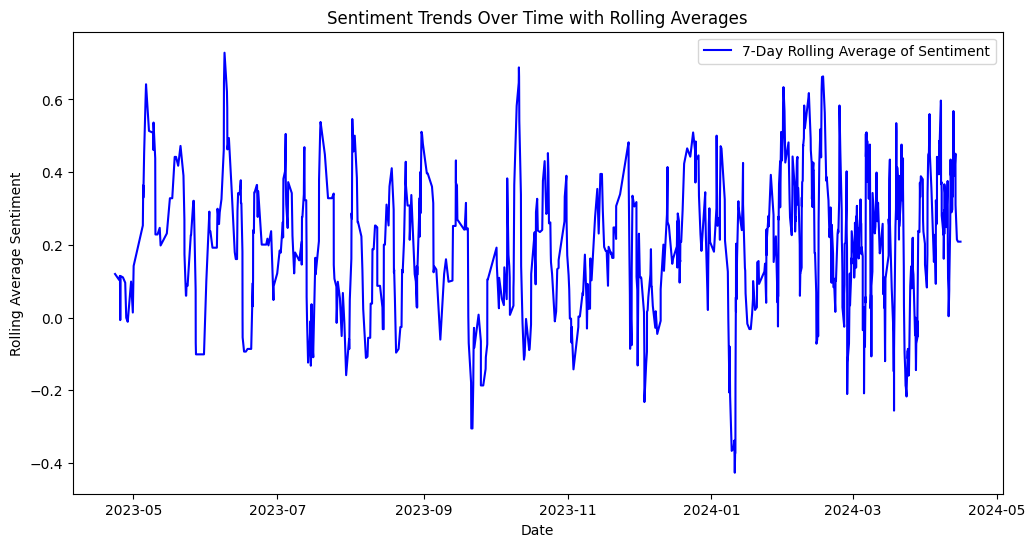

In [41]:
# Smooth out daily fluctuations in sentiment to see longer-term trends more clearly.

# Calculate rolling average of sentiment
df_posts['rolling_sentiment'] = df_posts['sentiment'].rolling(window=7, center=True).mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(df_posts['created_utc'], df_posts['rolling_sentiment'], label='7-Day Rolling Average of Sentiment', color='blue')
plt.title('Sentiment Trends Over Time with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Rolling Average Sentiment')
plt.legend()
plt.show()


### Comparative Analysis of Sentiment Between Top 5 Most Active Users

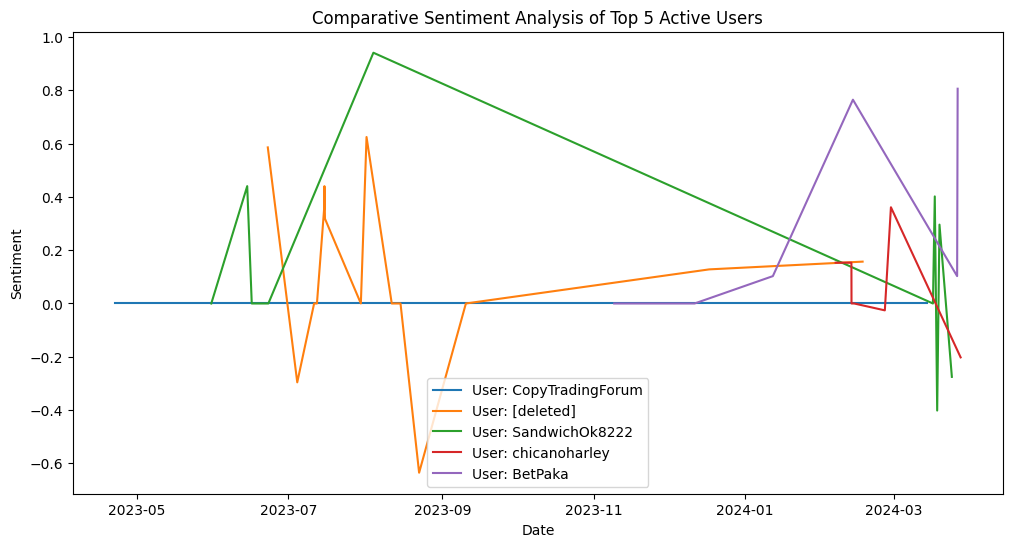

In [42]:
# Determine if more active users have a consistent sentiment in their posts.

# Identify top 5 active users
top_users = df_posts['username'].value_counts().nlargest(5).index

# Filter posts by these users
top_user_posts = df_posts[df_posts['username'].isin(top_users)]

# Plot
plt.figure(figsize=(12, 6))
for user in top_users:
    user_posts = top_user_posts[top_user_posts['username'] == user]
    plt.plot(user_posts['created_utc'], user_posts['sentiment'], label=f"User: {user}")

plt.title('Comparative Sentiment Analysis of Top 5 Active Users')
plt.xlabel('Date')
plt.ylabel('Sentiment')
plt.legend()
plt.show()


### Word Cloud of Most Common Words in Positive and Negative Posts

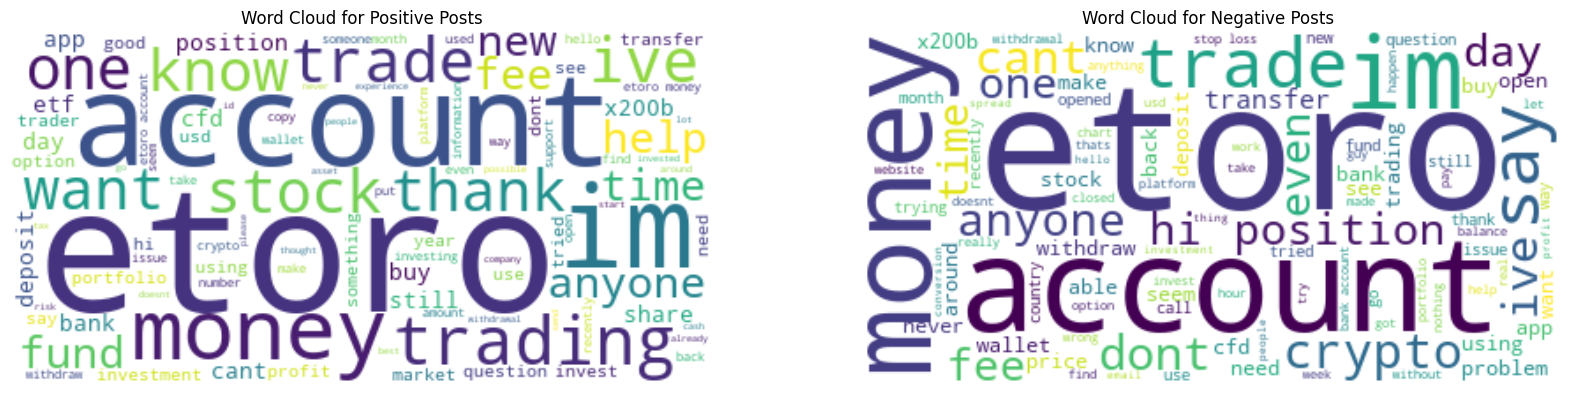

In [44]:
# Visualize the most frequent terms in different sentiment categories to identify common themes or concerns
from wordcloud import WordCloud

# Generate word clouds for positive and negative posts
positive_text = ' '.join(df_posts[df_posts['sentiment'] > 0]['body'])
negative_text = ' '.join(df_posts[df_posts['sentiment'] < 0]['body'])

positive_wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(positive_text)
negative_wordcloud = WordCloud(max_font_size=100, max_words=100, background_color="white").generate(negative_text)

# Display the word clouds
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.title('Word Cloud for Positive Posts')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.title('Word Cloud for Negative Posts')
plt.axis("off")
plt.show()


### Distribution of Post Lengths by Sentiment Category

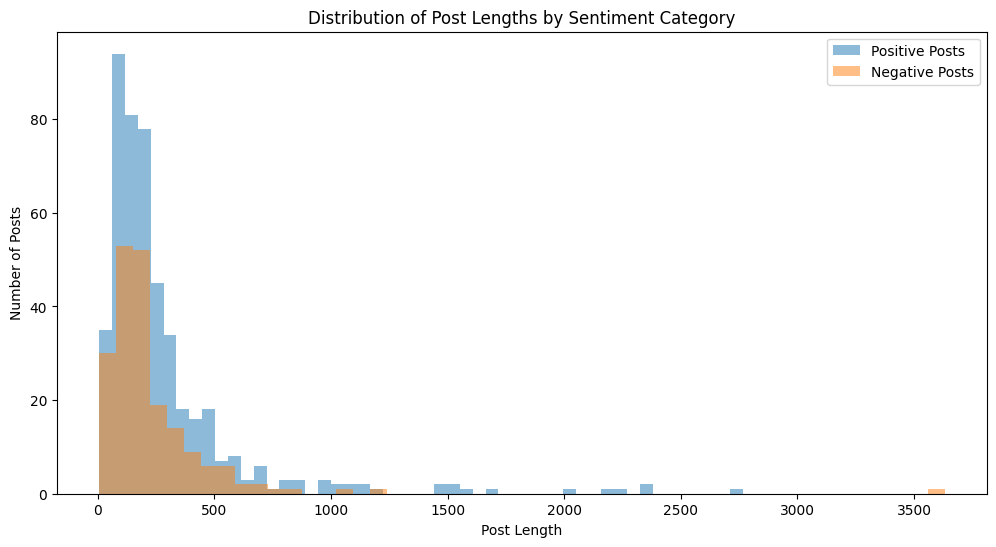

In [45]:
# Check if longer texts tend to be more positive or negative

# Calculate post length
df_posts['post_length'] = df_posts['body'].apply(len)

# Plot histograms
plt.figure(figsize=(12, 6))
plt.hist(df_posts[df_posts['sentiment'] > 0]['post_length'], bins=50, alpha=0.5, label='Positive Posts')
plt.hist(df_posts[df_posts['sentiment'] < 0]['post_length'], bins=50, alpha=0.5, label='Negative Posts')
plt.title('Distribution of Post Lengths by Sentiment Category')
plt.xlabel('Post Length')
plt.ylabel('Number of Posts')
plt.legend()
plt.show()


### Correlation Heatmap of Numeric Features

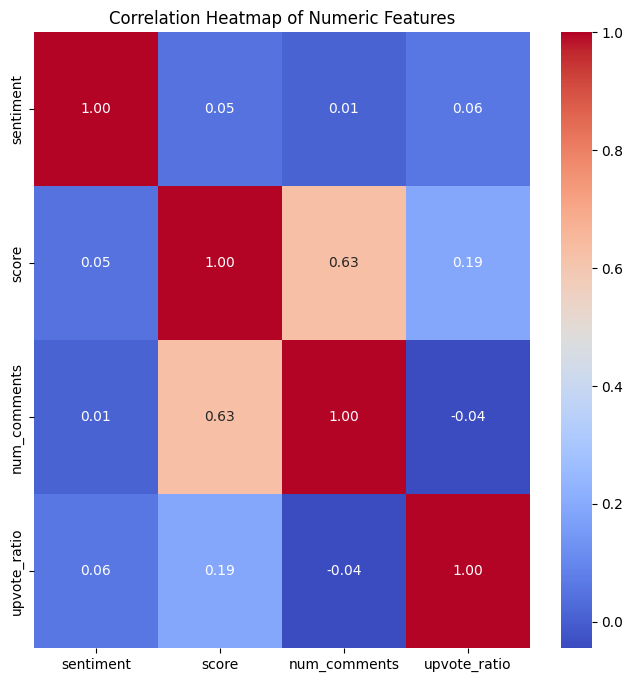

In [46]:
import seaborn as sns

# Select numeric features
features = df_posts[['sentiment', 'score', 'num_comments', 'upvote_ratio']]

# Calculate correlation matrix
corr_matrix = features.corr()

# Generate a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


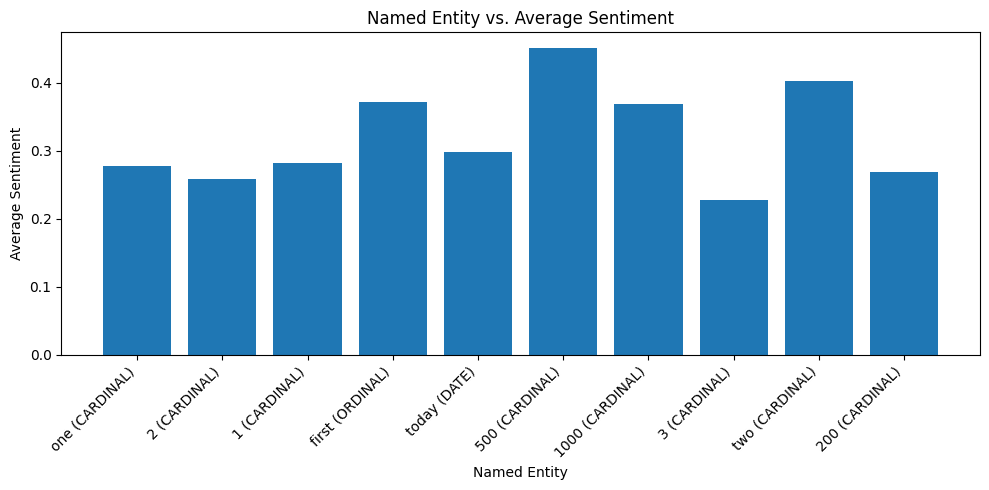

In [47]:
# Calculate average sentiment for each named entity
entity_sentiment = {}
for entity, count in entity_counts.most_common(10):
    entity_posts = df_posts[df_posts['body'].str.contains(entity[0])]
    entity_sentiment[entity] = entity_posts['sentiment'].mean()

# Plot named entity vs. sentiment
plt.figure(figsize=(10, 5))
plt.bar(range(len(entity_sentiment)), list(entity_sentiment.values()))
plt.xticks(range(len(entity_sentiment)), [f"{entity[0]} ({entity[1]})" for entity in entity_sentiment.keys()], rotation=45, ha='right')
plt.title('Named Entity vs. Average Sentiment')
plt.xlabel('Named Entity')
plt.ylabel('Average Sentiment')
plt.tight_layout()
plt.show()

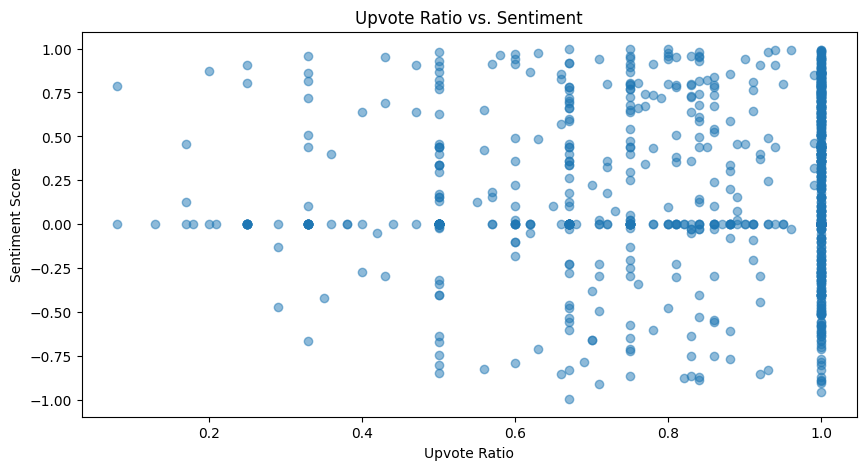

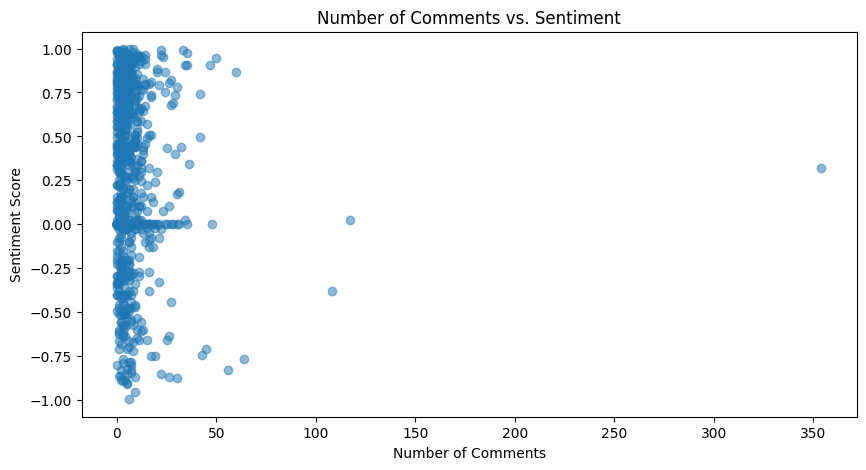

In [48]:
# Plot upvote ratio vs. sentiment
plt.figure(figsize=(10, 5))
plt.scatter(df_posts['upvote_ratio'], df_posts['sentiment'], alpha=0.5)
plt.title('Upvote Ratio vs. Sentiment')
plt.xlabel('Upvote Ratio')
plt.ylabel('Sentiment Score')
plt.show()

# Plot number of comments vs. sentiment
plt.figure(figsize=(10, 5))
plt.scatter(df_posts['num_comments'], df_posts['sentiment'], alpha=0.5)
plt.title('Number of Comments vs. Sentiment')
plt.xlabel('Number of Comments')
plt.ylabel('Sentiment Score')
plt.show()

In [51]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Topic modeling
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df_posts['body'])
lda = LatentDirichletAllocation(n_components=5)
topics = lda.fit_transform(dtm)

# Display top words per topic
words = vectorizer.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx}: " + " ".join([words[i] for i in topic.argsort()[:-10 - 1:-1]]))


AttributeError: 'CountVectorizer' object has no attribute 'get_feature_names'

In [52]:
import networkx as nx

# Build a graph of interactions based on comments
G = nx.Graph()
for _, row in df_comments.iterrows():
    G.add_node(row['comment_author'])
    parent_author = df_comments.loc[df_comments['comment_id'] == row['parent_id'], 'comment_author'].values[0]
    if parent_author:
        G.add_edge(row['comment_author'], parent_author)

# Draw the graph
plt.figure(figsize=(12, 12))
nx.draw_networkx(G, with_labels=False, node_size=20, alpha=0.6)
plt.title('Network of User Interactions')
plt.show()


IndexError: index 0 is out of bounds for axis 0 with size 0

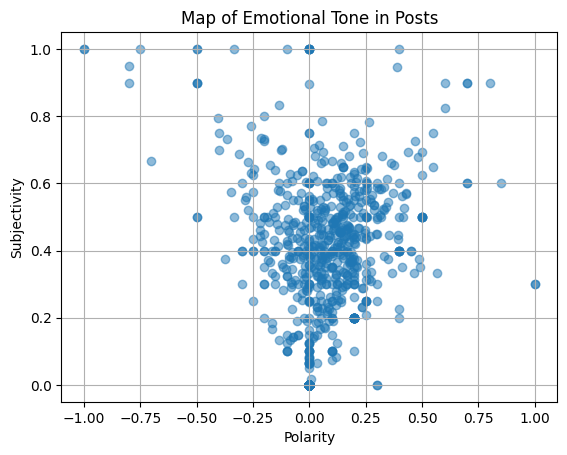

In [54]:
from textblob import TextBlob

# Emotional tone mapping
df_posts['polarity'] = df_posts['body'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_posts['subjectivity'] = df_posts['body'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Visualize
plt.scatter(df_posts['polarity'], df_posts['subjectivity'], alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.title('Map of Emotional Tone in Posts')
plt.grid(True)
plt.show()
